# Checkerboard 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from comet_ml import Experiment
import tensorflow as tf

# This giver the path to the enviroment the jupyter notebook is on
#import sys
#print(sys.executable)

In [4]:
# Set up YOUR experiment - login to comet, create new project (for new exercise)
# and copy the statet command
# or just change the name of the workspace, and the API (you can find it in the settings)
experiment = Experiment(
    api_key="EnterYourAPIKey",
    project_name="exercise0",
    workspace="EnterGroupWorkspaceHere",
)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: The given API key EnterYourAPIKey is invalid on www.comet.com, please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/v2/api-and-sdk/python-sdk/warnings-errors/
COMET ERROR: The given API key EnterYourAPIKey is invalid on www.comet.com, please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/v2/api-and-sdk/python-sdk/warnings-errors/


In [5]:
# ------------------------------------------
# Data
# ------------------------------------------
np.random.seed(1337)  # for reproducibility

# x = (x1, x2) with random numbers x1, x2 ~ Uniform(-1, 1)
# y ~ XOR(x1, x2)
N = 1000
lr = 0.05  # learning rate
xdata = (2 * np.random.rand(N, 2) - 1).astype(np.float32)  # shape = (N, 2)
ydata = (xdata[:, 0] * xdata[:, 1]) < 0  # shape = (N)
ydata = ydata.reshape(N, 1)  # shape = (N, 1)

In [6]:
# setup model
class Model(object):
    def __init__(self, n1):
        random_normal = tf.initializers.RandomNormal()
        self.W_1 = tf.Variable(random_normal([2, n1]))
        self.b_1 = tf.Variable(tf.zeros(n1))
        self.W_last = tf.Variable(tf.random.normal([n1, 1]))
        self.b_last = tf.Variable(tf.zeros(1))

    def __call__(self, x):
        h = tf.matmul(x, self.W_1)
        h1 = tf.nn.relu(h + self.b_1)
        return tf.sigmoid(tf.matmul(h1, self.W_last) + self.b_last)

In [7]:
# define loss: mean squared error
def objective(x, y):
    return tf.reduce_mean(tf.square(y - x))

# accuracy (= fraction of correct predictions)
def accuracy(x, y):
    correct_prediction = tf.equal(y, tf.round(x))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
# train your model
model = Model(n1=4)

for i in range(5000):

    with tf.GradientTape() as tape:

        # foward pass
        current_loss = objective(model(xdata), ydata)
        acc = accuracy(model(xdata), ydata)
        experiment.log_metric("loss", current_loss)  # log metric to comet
        experiment.log_metric("accuracy", acc)  # log metric to comet

        if i % 200 == 0:
            print("iteration:", i, "loss", current_loss, "accuracy", acc)

        # backward pass
        dW_1, db_1, dW_last, db_last = tape.gradient(
            current_loss, [model.W_1, model.b_1, model.W_last, model.b_last]
        )
        model.W_1.assign_sub(
            lr * dW_1
        )  # update model parameters assign_sub -> W -= lr * dW (gradient descent)
        model.b_1.assign_sub(lr * db_1)
        model.W_last.assign_sub(lr * dW_last)
        model.b_last.assign_sub(lr * db_last)

iteration: 0 loss tf.Tensor(0.24712738, shape=(), dtype=float32) accuracy tf.Tensor(0.7, shape=(), dtype=float32)
iteration: 200 loss tf.Tensor(0.21910553, shape=(), dtype=float32) accuracy tf.Tensor(0.75, shape=(), dtype=float32)
iteration: 400 loss tf.Tensor(0.19906133, shape=(), dtype=float32) accuracy tf.Tensor(0.824, shape=(), dtype=float32)
iteration: 600 loss tf.Tensor(0.17902468, shape=(), dtype=float32) accuracy tf.Tensor(0.838, shape=(), dtype=float32)
iteration: 800 loss tf.Tensor(0.16081394, shape=(), dtype=float32) accuracy tf.Tensor(0.852, shape=(), dtype=float32)
iteration: 1000 loss tf.Tensor(0.14587449, shape=(), dtype=float32) accuracy tf.Tensor(0.851, shape=(), dtype=float32)
iteration: 1200 loss tf.Tensor(0.13417615, shape=(), dtype=float32) accuracy tf.Tensor(0.858, shape=(), dtype=float32)
iteration: 1400 loss tf.Tensor(0.12499187, shape=(), dtype=float32) accuracy tf.Tensor(0.861, shape=(), dtype=float32)
iteration: 1600 loss tf.Tensor(0.11766007, shape=(), dtype

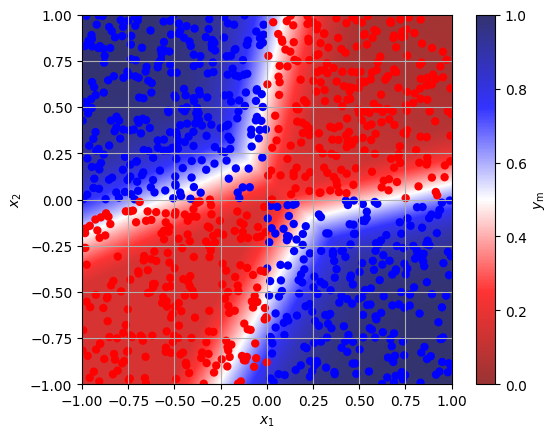

In [9]:
# ------------------------------------------
# Evaluation
# ------------------------------------------
# Compute the model prediction on a grid of 500 x 500 points
n = 500
s = np.linspace(-1, 1, n).astype(np.float32)
xp = np.array(
    np.meshgrid(s, s)
)  # xp.shape = (2, 500, 500), all combinations of s with s
xp = xp.T  # xp.shape = (500, 500, 2)
xp = xp.reshape((-1, 2))  # xp.shape = (500*500, 2), reshape
yp = model(xp)  # yp.shape = (500*500, 1), model prediction
yp = np.array(yp)  # convert to numpy array
yp = yp.reshape((n, n))  # yp.shape = (500, 500), reshape

# plot model prediction
fig, ax = plt.subplots(1)
im = ax.imshow(
    yp,
    extent=(-1, 1, -1, 1),
    origin="lower",
    vmin=0,
    vmax=1,
    cmap=plt.cm.seismic_r,
    alpha=0.8,
)
cbar = plt.colorbar(im)
cbar.set_label("$y_\mathrm{m}$")

# plot data
colors = ["blue" if y else "red" for y in ydata]  # 'blue' for y=1 and 'red' for y=0
ax.scatter(*xdata.T, c=colors, lw=0)

ax.set(xlabel="$x_1$", ylabel="$x_2$", aspect="equal")
ax.grid(True)
fig.savefig("checkerboard.png", bbox_inches="tight")


## Exercises


1: Verify TensorFlow by computing the network output and loss using pure numpy.
   You can retrieve the weights and biases using
   Bonus: Don't loop over the data.

2: Change the number of neurons in the hidden layer to 8 (and to 2) and retrain the model.

3: Add an additional hidden layer of 4 neurons with ReLU as activation and retrain the model.
